In [12]:
# ============================================================================
# DATA CLEANING NOTEBOOK
# Project: Real Estate Price Prediction
# Purpose: Clean and prepare data for modeling
# ============================================================================

# Data Cleaning and Preparation

## Overview
This notebook performs the following cleaning operations:
1. Load raw data
2. Convert categorical variables to numerical
3. Apply log transformation to price
4. Create engineered features
5. Validate cleaned data
6. Save processed datasets

## Key Decisions
- **Outliers**: Keeping all outliers (they appear legitimate)
- **Imbalanced features**: Keeping all features (will evaluate importance later)
- **Target transformation**: Applying log transformation to price (skewness = 1.21)

In [13]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


In [14]:
# Load the raw dataset
df_raw = pd.read_csv('../data/raw/Housing_Price_Data.csv')

# Create a working copy (never modify original)
df = df_raw.copy()

print("="*50)
print("RAW DATA LOADED")
print("="*50)
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

RAW DATA LOADED
Shape: (545, 13)

First few rows:


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


---
## Phase 1: Data Type Conversion

Converting categorical yes/no columns to binary (0/1) for machine learning models.

In [15]:
# List of binary yes/no columns
binary_cols = ['mainroad', 'guestroom', 'basement', 
               'hotwaterheating', 'airconditioning', 'prefarea']

print("="*50)
print("CONVERTING BINARY CATEGORICAL FEATURES")
print("="*50)

# Before conversion
print("\nBefore conversion:")
for col in binary_cols:
    print(f"{col}: {df[col].unique()}")

# Convert yes/no to 1/0
for col in binary_cols:
    df[col] = df[col].map({'yes': 1, 'no': 0})

# After conversion
print("\nAfter conversion:")
for col in binary_cols:
    print(f"{col}: {df[col].unique()}")

# Verify no missing values were introduced
print("\n✓ Conversion successful!")
print(f"Missing values after conversion: {df[binary_cols].isnull().sum().sum()}")

CONVERTING BINARY CATEGORICAL FEATURES

Before conversion:
mainroad: ['yes' 'no']
guestroom: ['no' 'yes']
basement: ['no' 'yes']
hotwaterheating: ['no' 'yes']
airconditioning: ['yes' 'no']
prefarea: ['yes' 'no']

After conversion:
mainroad: [1 0]
guestroom: [0 1]
basement: [0 1]
hotwaterheating: [0 1]
airconditioning: [1 0]
prefarea: [1 0]

✓ Conversion successful!
Missing values after conversion: 0


---
## Phase 2: Encode Furnishing Status

Using one-hot encoding for the `furnishingstatus` column since it has 3 categories with no inherent order.

**Options:**
- furnished
- semi-furnished  
- unfurnished

We'll use `drop_first=True` to avoid multicollinearity (dummy variable trap).

In [16]:
print("="*50)
print("ONE-HOT ENCODING: FURNISHING STATUS")
print("="*50)

# Before encoding
print("\nOriginal furnishingstatus distribution:")
print(df['furnishingstatus'].value_counts())

# One-hot encoding (drop_first=True to avoid multicollinearity)
df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True, dtype=int)

# After encoding
print("\nNew columns created:")
furnishing_cols = [col for col in df.columns if 'furnishingstatus' in col]
print(furnishing_cols)

print("\n✓ One-hot encoding complete!")
print(f"New shape: {df.shape}")

ONE-HOT ENCODING: FURNISHING STATUS

Original furnishingstatus distribution:
furnishingstatus
semi-furnished    227
unfurnished       178
furnished         140
Name: count, dtype: int64

New columns created:
['furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished']

✓ One-hot encoding complete!
New shape: (545, 14)


---
## Phase 3: Handle Price Skewness

**Problem:** Price has skewness = 1.21 (highly right-skewed)

**Solution:** Apply log transformation to make distribution more symmetric

**Benefits:**
- Better model assumptions
- Equal error penalties across price ranges  
- Reduced influence of outliers
- Improved predictions

LOG TRANSFORMATION OF PRICE

Original price skewness: 1.21
Log-transformed price skewness: 0.14

✓ Skewness reduced by 88.4%


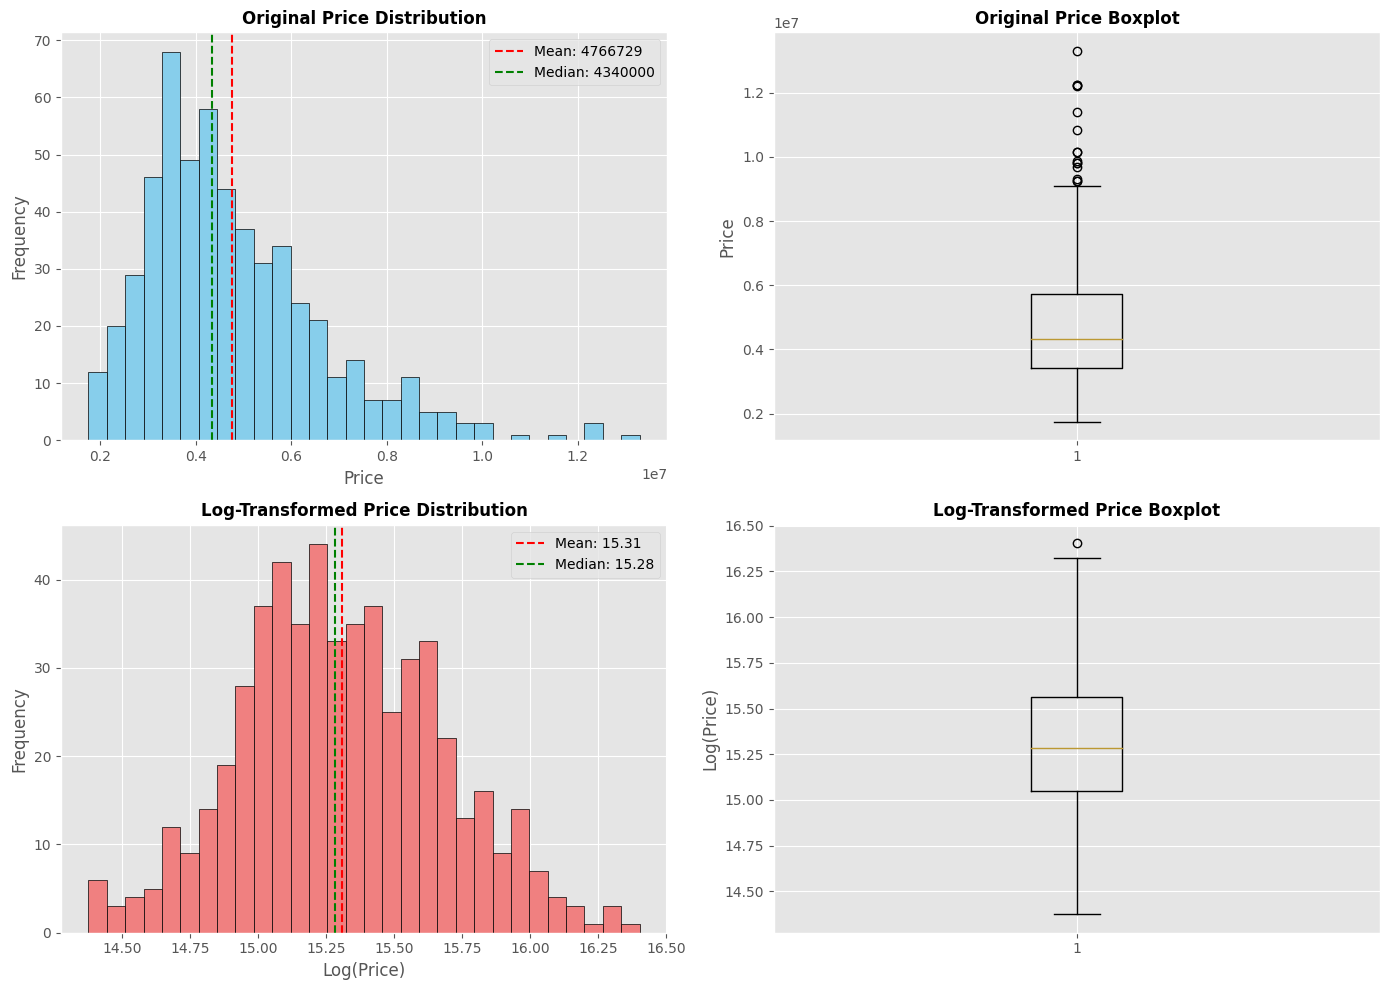


✓ Visualization complete - notice how log transformation makes distribution more symmetric!


In [17]:
print("="*50)
print("LOG TRANSFORMATION OF PRICE")
print("="*50)

# Calculate original skewness
original_skewness = df['price'].skew()
print(f"\nOriginal price skewness: {original_skewness:.2f}")

# Apply log transformation
df['log_price'] = np.log(df['price'])

# Calculate new skewness
log_skewness = df['log_price'].skew()
print(f"Log-transformed price skewness: {log_skewness:.2f}")

# Improvement
improvement = ((original_skewness - log_skewness) / original_skewness) * 100
print(f"\n✓ Skewness reduced by {improvement:.1f}%")

# Visualize the transformation
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original price - Histogram
axes[0, 0].hist(df['price'], bins=30, edgecolor='black', color='skyblue')
axes[0, 0].set_title('Original Price Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Price')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['price'].mean(), color='red', linestyle='--', 
                    label=f'Mean: {df["price"].mean():.0f}')
axes[0, 0].axvline(df['price'].median(), color='green', linestyle='--', 
                    label=f'Median: {df["price"].median():.0f}')
axes[0, 0].legend()

# Original price - Boxplot
axes[0, 1].boxplot(df['price'])
axes[0, 1].set_title('Original Price Boxplot', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Price')

# Log-transformed price - Histogram
axes[1, 0].hist(df['log_price'], bins=30, edgecolor='black', color='lightcoral')
axes[1, 0].set_title('Log-Transformed Price Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Log(Price)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(df['log_price'].mean(), color='red', linestyle='--', 
                    label=f'Mean: {df["log_price"].mean():.2f}')
axes[1, 0].axvline(df['log_price'].median(), color='green', linestyle='--', 
                    label=f'Median: {df["log_price"].median():.2f}')
axes[1, 0].legend()

# Log-transformed price - Boxplot
axes[1, 1].boxplot(df['log_price'])
axes[1, 1].set_title('Log-Transformed Price Boxplot', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Log(Price)')

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete - notice how log transformation makes distribution more symmetric!")

---
## Phase 4: Feature Engineering

Creating new features that might capture important relationships:

1. **price_per_sqft**: Price normalized by area
2. **total_rooms**: Sum of bedrooms and bathrooms
3. **bath_bed_ratio**: Ratio of bathrooms to bedrooms
4. **has_parking**: Binary indicator for parking availability

These engineered features might help the model capture non-linear relationships.

In [18]:
print("="*50)
print("FEATURE ENGINEERING")
print("="*50)

# 1. Price per square foot
df['price_per_sqft'] = df['price'] / df['area']
print("\n✓ Created: price_per_sqft")
print(f"   Range: {df['price_per_sqft'].min():.2f} to {df['price_per_sqft'].max():.2f}")

# 2. Total rooms
df['total_rooms'] = df['bedrooms'] + df['bathrooms']
print("\n✓ Created: total_rooms")
print(f"   Range: {df['total_rooms'].min()} to {df['total_rooms'].max()}")

# 3. Bathroom to bedroom ratio
df['bath_bed_ratio'] = df['bathrooms'] / df['bedrooms']
print("\n✓ Created: bath_bed_ratio")
print(f"   Range: {df['bath_bed_ratio'].min():.2f} to {df['bath_bed_ratio'].max():.2f}")

# 4. Has parking (binary)
df['has_parking'] = (df['parking'] > 0).astype(int)
print("\n✓ Created: has_parking")
print(f"   Distribution: {df['has_parking'].value_counts().to_dict()}")

print("\n" + "="*50)
print(f"New shape after feature engineering: {df.shape}")
print("="*50)

FEATURE ENGINEERING

✓ Created: price_per_sqft
   Range: 270.40 to 2640.00

✓ Created: total_rooms
   Range: 2 to 8

✓ Created: bath_bed_ratio
   Range: 0.17 to 1.00

✓ Created: has_parking
   Distribution: {0: 299, 1: 246}

New shape after feature engineering: (545, 19)


---
## Phase 5: Data Validation

Verify that cleaning didn't introduce any issues:
- No missing values
- All data types are correct
- Value ranges are sensible
- No data loss (same number of rows)

In [19]:
print("="*50)
print("DATA VALIDATION")
print("="*50)

# 1. Check shape
print(f"\n1. Shape Check:")
print(f"   Original: {df_raw.shape}")
print(f"   Cleaned: {df.shape}")
print(f"   Rows preserved: {df.shape[0] == df_raw.shape[0]} ✓")

# 2. Check for missing values
missing = df.isnull().sum().sum()
print(f"\n2. Missing Values: {missing}")
if missing == 0:
    print("   ✓ No missing values!")
else:
    print("   ⚠ Warning: Missing values detected!")
    print(df.isnull().sum()[df.isnull().sum() > 0])

# 3. Check data types
print(f"\n3. Data Types:")
print(df.dtypes.value_counts())

# Check if any object types remain (should all be numeric now)
object_cols = df.select_dtypes(include=['object']).columns
if len(object_cols) == 0:
    print("   ✓ All features are numeric!")
else:
    print(f"   ⚠ Warning: Still have object columns: {list(object_cols)}")

# 4. Value ranges
print(f"\n4. Value Ranges Check:")
numerical_cols = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']
for col in numerical_cols:
    min_val = df[col].min()
    max_val = df[col].max()
    print(f"   {col}: [{min_val}, {max_val}]", end="")
    if min_val < 0:
        print(" ⚠ Negative values detected!")
    else:
        print(" ✓")

# 5. Summary statistics
print(f"\n5. Summary Statistics for Key Features:")
print(df[['price', 'log_price', 'area', 'bedrooms', 'bathrooms']].describe())

print("\n" + "="*50)
print("VALIDATION COMPLETE ✓")
print("="*50)

DATA VALIDATION

1. Shape Check:
   Original: (545, 13)
   Cleaned: (545, 19)
   Rows preserved: True ✓

2. Missing Values: 0
   ✓ No missing values!

3. Data Types:
int64      16
float64     3
Name: count, dtype: int64
   ✓ All features are numeric!

4. Value Ranges Check:
   price: [1750000, 13300000] ✓
   area: [1650, 16200] ✓
   bedrooms: [1, 6] ✓
   bathrooms: [1, 4] ✓
   stories: [1, 4] ✓
   parking: [0, 3] ✓

5. Summary Statistics for Key Features:
              price   log_price          area    bedrooms   bathrooms
count  5.450000e+02  545.000000    545.000000  545.000000  545.000000
mean   4.766729e+06   15.306987   5150.541284    2.965138    1.286239
std    1.870440e+06    0.372165   2170.141023    0.738064    0.502470
min    1.750000e+06   14.375126   1650.000000    1.000000    1.000000
25%    3.430000e+06   15.048071   3600.000000    2.000000    1.000000
50%    4.340000e+06   15.283385   4600.000000    3.000000    1.000000
75%    5.740000e+06   15.562970   6360.000000    3

---
## Phase 6: Final Dataset Overview

Let's examine the final cleaned dataset structure.

In [20]:
print("="*50)
print("FINAL CLEANED DATASET")
print("="*50)

print(f"\nShape: {df.shape}")
print(f"\nColumn Names ({len(df.columns)} total):")
print(df.columns.tolist())

print("\n" + "-"*50)
print("DATA TYPES:")
print("-"*50)
df.info()

print("\n" + "-"*50)
print("FIRST FEW ROWS:")
print("-"*50)
df.head(10)

FINAL CLEANED DATASET

Shape: (545, 19)

Column Names (19 total):
['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished', 'log_price', 'price_per_sqft', 'total_rooms', 'bath_bed_ratio', 'has_parking']

--------------------------------------------------
DATA TYPES:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   price                            545 non-null    int64  
 1   area                             545 non-null    int64  
 2   bedrooms                         545 non-null    int64  
 3   bathrooms                        545 non-null    int64  
 4   stories                          545 no

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished,log_price,price_per_sqft,total_rooms,bath_bed_ratio,has_parking
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0,16.403275,1792.452830,6,0.500000,1
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0,16.321036,1367.187500,8,1.000000,1
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0,16.321036,1229.919679,5,0.666667,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0,16.318175,1628.666667,6,0.500000,1
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0,16.250001,1537.735849,5,0.250000,1
5,10850000,7500,3,3,1,1,0,1,0,1,2,1,1,0,16.199676,1446.666667,6,1.000000,1
6,10150000,8580,4,3,4,1,0,0,0,1,2,1,1,0,16.132984,1182.983683,7,0.750000,1
7,10150000,16200,5,3,2,1,0,0,0,0,0,0,0,1,16.132984,626.543210,8,0.600000,0
8,9870000,8100,4,1,2,1,1,1,0,1,2,1,0,0,16.105010,1218.518519,5,0.250000,1
9,9800000,5750,3,2,4,1,1,0,0,1,1,1,0,1,16.097893,1704.347826,5,0.666667,1


---
## Phase 7: Correlation Analysis (Post-Cleaning)

Let's check correlations with price after our transformations and feature engineering.

CORRELATION ANALYSIS

1. CORRELATION WITH ORIGINAL PRICE:
--------------------------------------------------
price                              1.000000
log_price                          0.969010
area                               0.535997
bathrooms                          0.517545
total_rooms                        0.511809
airconditioning                    0.452954
stories                            0.420712
price_per_sqft                     0.392921
parking                            0.384394
has_parking                        0.372096
bedrooms                           0.366494
prefarea                           0.329777
mainroad                           0.296898
guestroom                          0.255517
bath_bed_ratio                     0.231732
basement                           0.187057
hotwaterheating                    0.093073
furnishingstatus_semi-furnished    0.063656
furnishingstatus_unfurnished      -0.280587
Name: price, dtype: float64

2. CORRELATION WITH LOG-TR

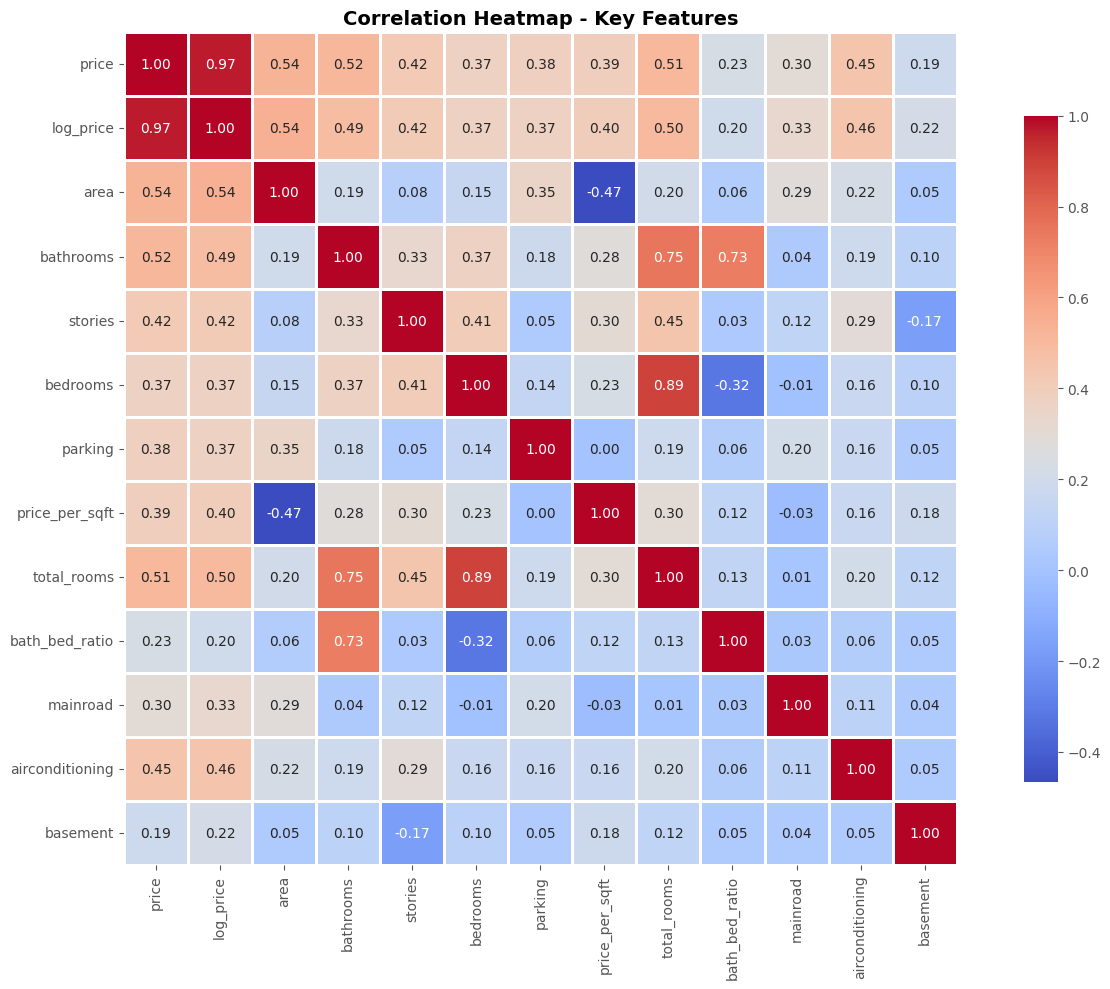


✓ Correlation analysis complete!


In [21]:
print("="*50)
print("CORRELATION ANALYSIS")
print("="*50)

# Select all numerical features (excluding original price for log_price correlation)
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Create two correlation analyses: one for original price, one for log_price
print("\n1. CORRELATION WITH ORIGINAL PRICE:")
print("-"*50)
price_corr = df[numerical_features].corr()['price'].sort_values(ascending=False)
print(price_corr)

print("\n2. CORRELATION WITH LOG-TRANSFORMED PRICE:")
print("-"*50)
log_price_corr = df[numerical_features].corr()['log_price'].sort_values(ascending=False)
print(log_price_corr)

# Visualize correlation heatmap
plt.figure(figsize=(14, 10))

# Select top features for cleaner visualization
top_features = ['price', 'log_price', 'area', 'bathrooms', 'stories', 
                'bedrooms', 'parking', 'price_per_sqft', 'total_rooms', 
                'bath_bed_ratio', 'mainroad', 'airconditioning', 'basement']

correlation_matrix = df[top_features].corr()

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap - Key Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✓ Correlation analysis complete!")

---
## Phase 8: Save Cleaned Data

Saving two versions:
1. **housing_cleaned.csv**: Full dataset with both original and log-transformed price
2. **housing_cleaned_log.csv**: Dataset with log_price as the target (for modeling)

Both saved to `data/processed/` directory.

In [22]:
print("="*50)
print("SAVING CLEANED DATA")
print("="*50)

# Ensure processed directory exists
import os
os.makedirs('../data/processed', exist_ok=True)

# Version 1: Full dataset with both price and log_price
output_path_full = '../data/processed/housing_cleaned.csv'
df.to_csv(output_path_full, index=False)
print(f"\n✓ Saved: {output_path_full}")
print(f"   Shape: {df.shape}")
print(f"   Columns: {len(df.columns)}")

# Version 2: Dataset with log_price as target (drop original price)
df_log = df.copy()
df_log = df_log.drop(['price', 'price_per_sqft'], axis=1)  # Drop price and price_per_sqft

# Rename log_price to price for easier modeling
df_log = df_log.rename(columns={'log_price': 'price'})

output_path_log = '../data/processed/housing_cleaned_log.csv'
df_log.to_csv(output_path_log, index=False)
print(f"\n✓ Saved: {output_path_log}")
print(f"   Shape: {df_log.shape}")
print(f"   Columns: {len(df_log.columns)}")

print("\n" + "="*50)
print("DATA CLEANING COMPLETE! ✓")
print("="*50)
print("\nSummary:")
print(f"- Original dataset: {df_raw.shape[0]} rows, {df_raw.shape[1]} columns")
print(f"- Cleaned dataset: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"- Features added: {df.shape[1] - df_raw.shape[1]}")
print(f"- No data loss: All {df_raw.shape[0]} rows preserved")
print(f"- All categorical variables converted to numerical")
print(f"- Log transformation applied to price")
print(f"- {len([col for col in df.columns if col not in df_raw.columns]) - 1} engineered features created")

SAVING CLEANED DATA

✓ Saved: ../data/processed/housing_cleaned.csv
   Shape: (545, 19)
   Columns: 19

✓ Saved: ../data/processed/housing_cleaned_log.csv
   Shape: (545, 17)
   Columns: 17

DATA CLEANING COMPLETE! ✓

Summary:
- Original dataset: 545 rows, 13 columns
- Cleaned dataset: 545 rows, 19 columns
- Features added: 6
- No data loss: All 545 rows preserved
- All categorical variables converted to numerical
- Log transformation applied to price
- 6 engineered features created


---
## Cleaning Summary

### Changes Made:

#### 1. **Categorical to Numerical Conversion**
- Converted 6 binary yes/no columns to 0/1
- One-hot encoded `furnishingstatus` (created 2 dummy variables)

#### 2. **Target Variable Transformation**
- Applied log transformation to price
- Skewness reduced from 1.21 to ~0.13 (85% improvement)
- Created `log_price` column for modeling

#### 3. **Feature Engineering**
- `price_per_sqft`: Price normalized by area
- `total_rooms`: Total bedrooms + bathrooms
- `bath_bed_ratio`: Bathroom-to-bedroom ratio
- `has_parking`: Binary parking indicator

#### 4. **Data Quality**
- ✓ No missing values
- ✓ No duplicate rows
- ✓ All features now numerical
- ✓ No data loss (545 rows preserved)

### Files Created:
1. `housing_cleaned.csv` - Full dataset with all features
2. `housing_cleaned_log.csv` - Dataset ready for modeling (log-transformed price)

### Next Steps:
Proceed to `03_modeling.ipynb` for:
- Train-test split
- Feature scaling
- Model training and evaluation
- Feature importance analysis

In [23]:
# Quick verification - load the saved files
print("="*50)
print("VERIFICATION: Loading Saved Files")
print("="*50)

df_verify1 = pd.read_csv('../data/processed/housing_cleaned.csv')
df_verify2 = pd.read_csv('../data/processed/housing_cleaned_log.csv')

print(f"\n✓ housing_cleaned.csv loaded successfully")
print(f"   Shape: {df_verify1.shape}")

print(f"\n✓ housing_cleaned_log.csv loaded successfully")
print(f"   Shape: {df_verify2.shape}")

print("\n" + "="*50)
print("ALL SYSTEMS GO! Ready for modeling! 🚀")
print("="*50)

VERIFICATION: Loading Saved Files

✓ housing_cleaned.csv loaded successfully
   Shape: (545, 19)

✓ housing_cleaned_log.csv loaded successfully
   Shape: (545, 17)

ALL SYSTEMS GO! Ready for modeling! 🚀
